In [48]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Make figures look good for hi-res displays.

In [49]:
df = pd.read_json('/data/diffusion/cdc_userstreams_top_25_retweeted_2020-06-05.json')
df.head(2)

,id,created_at,username,followers_count,followers_count_cumsum,text,top_N
0,1253786397288173568,2020-04-24 20:42:25+00:00,ronnie_rudolph,64,9952898,Household cleaners and disinfectants can cause...,1
1,1254038937825402880,2020-04-25 13:25:56+00:00,stewonthis1,11238,15751053,Household cleaners and disinfectants can cause...,1


For each retweeter present in both stream A and stream B, create a table with the rank in stream A and the rank in stream B

In [50]:
#We examine all retweets between Trump’s initial tweet and the end of the time period
def get_retweets_after_trump(df):
    retweets_after_trump = {}

    for t, retweets in df.groupby('top_N'):
        retweets.sort_values(by='created_at').reindex()
        index_of_trump_retweet = retweets[retweets.username == 'realDonaldTrump'].index
        if index_of_trump_retweet.any() > 0:
            print("Tweet TopN #: {}; ".format(t), end="")
            tweet = retweets.loc[min(index_of_trump_retweet)]
            print('@realDonaldTrump retweeted at '+ str( tweet.created_at))

            max_time = tweet.created_at + pd.Timedelta(hours=WINDOW)

            in_window = retweets[(retweets.created_at > tweet.created_at ) & (retweets.created_at <= max_time)]
            print(str(len(in_window)) + " retweets in {} hour(s) after Trump".format(WINDOW)+"\n")

            retweets_after_trump[t] = pd.DataFrame.copy(in_window)
            
    return retweets_after_trump

# Calculate the percentage of tweeters that are present in both streams:
# %similar= #present in both A and B / (min (count(a),count(b))
def calculate_similarity_of_tweeters_in_two_streams(streamA, streamB):
    return len( set(streamA.username) & set(streamB.username) ) / min(len(streamA),len(streamB) )* 100

# Pick two different retweet streams, say A and B.
# Rank the twitter users retweeting Trump in time order.  First retweeter = 1, second= 2, etc. for stream A and then separately for stream B
def rank_twitterers(streamA, streamB):
    
    users = set(streamA.username) & set(streamB.username)
    
    p_similar = calculate_similarity_of_tweeters_in_two_streams(streamA,streamB);

    if p_similar > 70:
        print("The % similar is: {:.2f} with {} users in both streams".format(p_similar, len(users)))
    
        #Now remove users from each stream that aren't present in both.
        A = list( streamA[ streamA.username.apply(lambda u: u in users) ].username )
        B = list( streamB[ streamB.username.apply(lambda u: u in users) ].username )

        to_return = []

        for u in list(users):
            to_return.append(
            {'user':u, 'rankInA':A.index(u), 'rankInB' : B.index(u)})


        thisDF = pd.DataFrame(to_return)

        sr = spearmanr(thisDF.rankInA, thisDF.rankInB)
        print(sr)

        return thisDF, sr
    else:
        return None, None

# For 1 Hour: 

Tweet TopN #: 2; @realDonaldTrump retweeted at 2020-04-25 13:04:07+00:00
798 retweets in 1 hour(s) after Trump

Tweet TopN #: 3; @realDonaldTrump retweeted at 2020-04-25 13:08:14+00:00
956 retweets in 1 hour(s) after Trump

Tweet TopN #: 4; @realDonaldTrump retweeted at 2020-05-25 02:29:05+00:00
973 retweets in 1 hour(s) after Trump

Tweet TopN #: 5; @realDonaldTrump retweeted at 2020-05-01 23:28:32+00:00
739 retweets in 1 hour(s) after Trump

Tweet TopN #: 6; @realDonaldTrump retweeted at 2020-04-25 13:05:26+00:00
815 retweets in 1 hour(s) after Trump

Tweet TopN #: 7; @realDonaldTrump retweeted at 2020-04-25 12:12:10+00:00
993 retweets in 1 hour(s) after Trump

Tweet TopN #: 8; @realDonaldTrump retweeted at 2020-04-25 13:05:51+00:00
807 retweets in 1 hour(s) after Trump

Tweet TopN #: 10; @realDonaldTrump retweeted at 2020-04-25 12:12:52+00:00
977 retweets in 1 hour(s) after Trump

Tweet TopN #: 11; @realDonaldTrump retweeted at 2020-04-25 13:07:15+00:00
773 retweets in 1 hour(s) aft

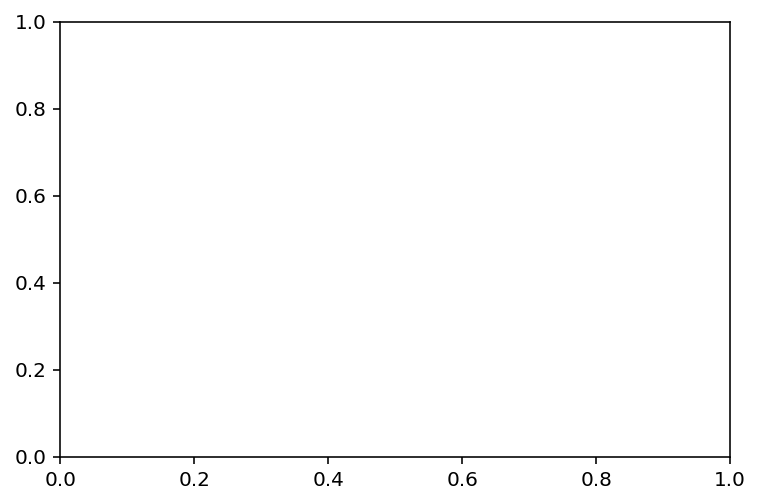

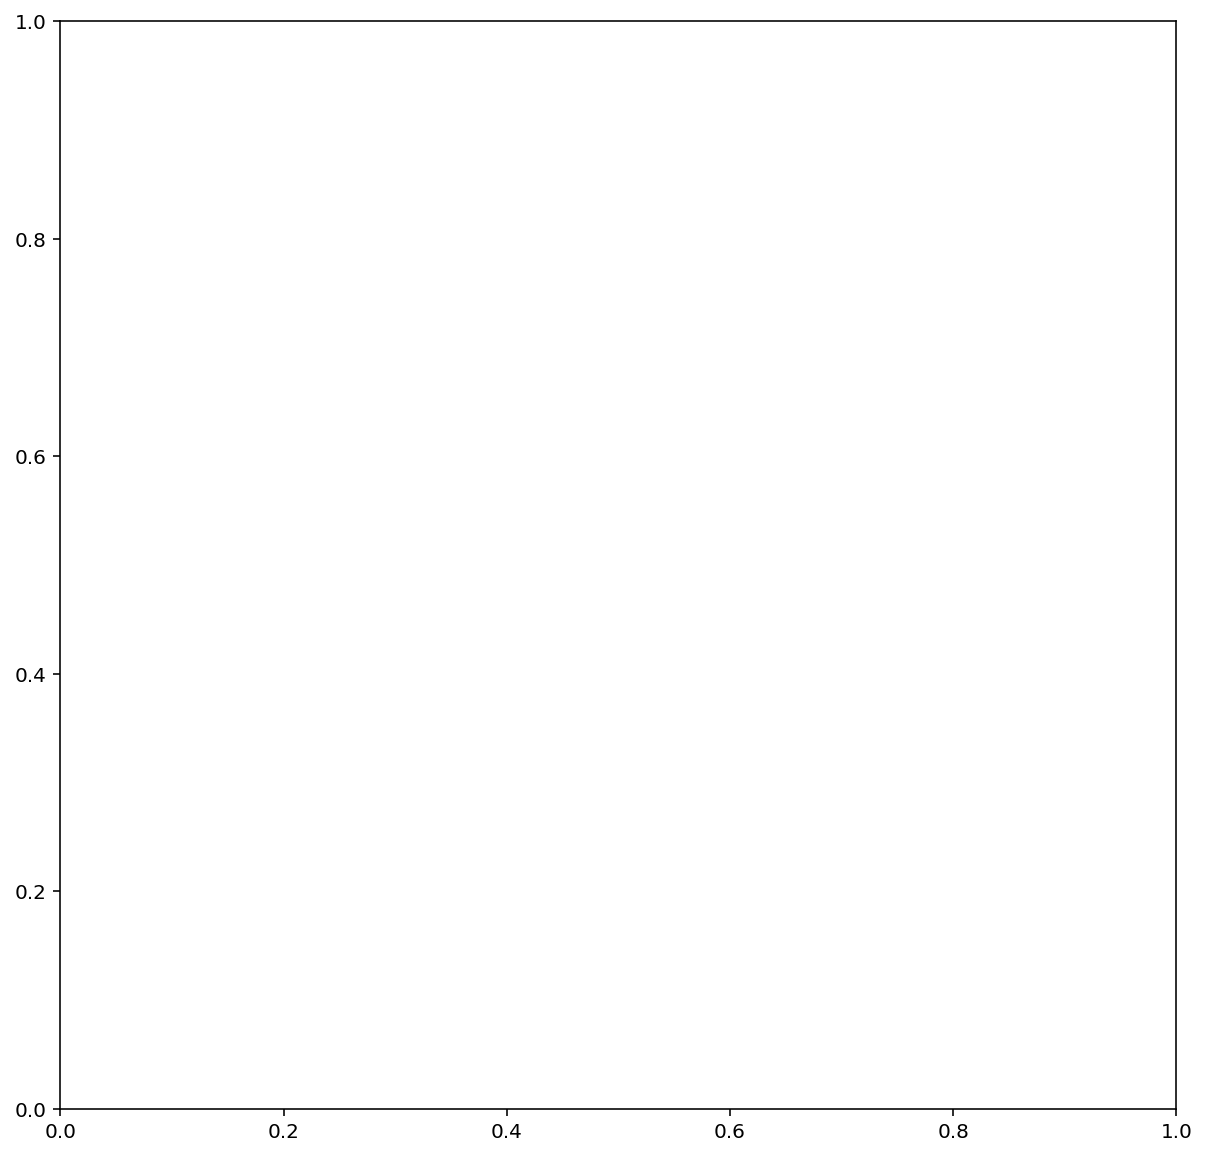

In [51]:
WINDOW = 1
retweets_after_trump = get_retweets_after_trump(df)

fig = plt.figure()
ax = fig.subplots(1,1)

# example
df2, sr = rank_twitterers(retweets_after_trump[8], retweets_after_trump[15])
ax = df2.plot(kind='scatter',x='rankInA',y='rankInB', figsize=(10,10))

for A in retweets_after_trump.keys():
    for B in retweets_after_trump.keys():
        if B > A:
            print("Tweets: {}, {}".format(A, B))
            print("--------------------")
            df2, sr = rank_twitterers(retweets_after_trump[A], retweets_after_trump[B])
            if df2 is not None:
                ax = df2.plot(kind='scatter',x='rankInA',y='rankInB', figsize=(10,10), ax=ax);
                ax.set_title("rankInA vs. rankInB");
                ax.set_xlabel("Tweet # {}".format(A));
                ax.set_ylabel("Tweet # {}".format(B));
                ax.get_figure().savefig('figs/{}_{}_window={}H.png'.format(A,B,WINDOW), dpi=144);
                ax.clear()
            print()

# For 24 Hours

Tweet TopN #: 2; @realDonaldTrump retweeted at 2020-04-25 13:04:07+00:00
2522 retweets in 24 hour(s) after Trump

Tweet TopN #: 3; @realDonaldTrump retweeted at 2020-04-25 13:08:14+00:00
3056 retweets in 24 hour(s) after Trump

Tweet TopN #: 4; @realDonaldTrump retweeted at 2020-05-25 02:29:05+00:00
3034 retweets in 24 hour(s) after Trump

Tweet TopN #: 5; @realDonaldTrump retweeted at 2020-05-01 23:28:32+00:00
2666 retweets in 24 hour(s) after Trump

Tweet TopN #: 6; @realDonaldTrump retweeted at 2020-04-25 13:05:26+00:00
2588 retweets in 24 hour(s) after Trump

Tweet TopN #: 7; @realDonaldTrump retweeted at 2020-04-25 12:12:10+00:00
2572 retweets in 24 hour(s) after Trump

Tweet TopN #: 8; @realDonaldTrump retweeted at 2020-04-25 13:05:51+00:00
2460 retweets in 24 hour(s) after Trump

Tweet TopN #: 10; @realDonaldTrump retweeted at 2020-04-25 12:12:52+00:00
2360 retweets in 24 hour(s) after Trump

Tweet TopN #: 11; @realDonaldTrump retweeted at 2020-04-25 13:07:15+00:00
2485 retweets

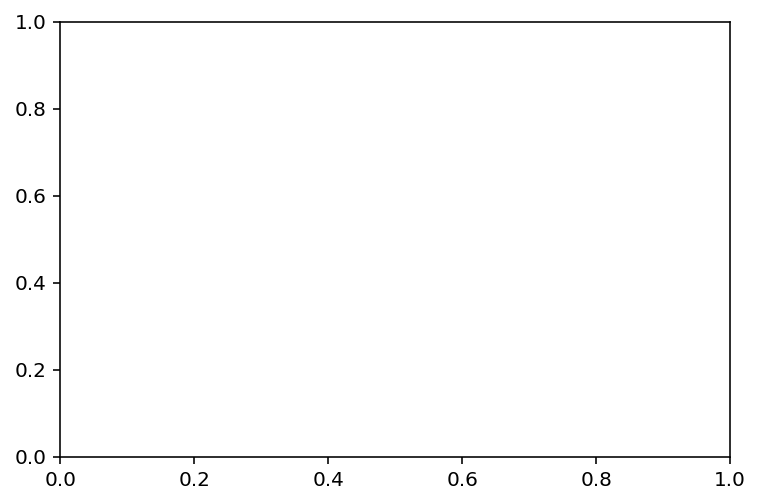

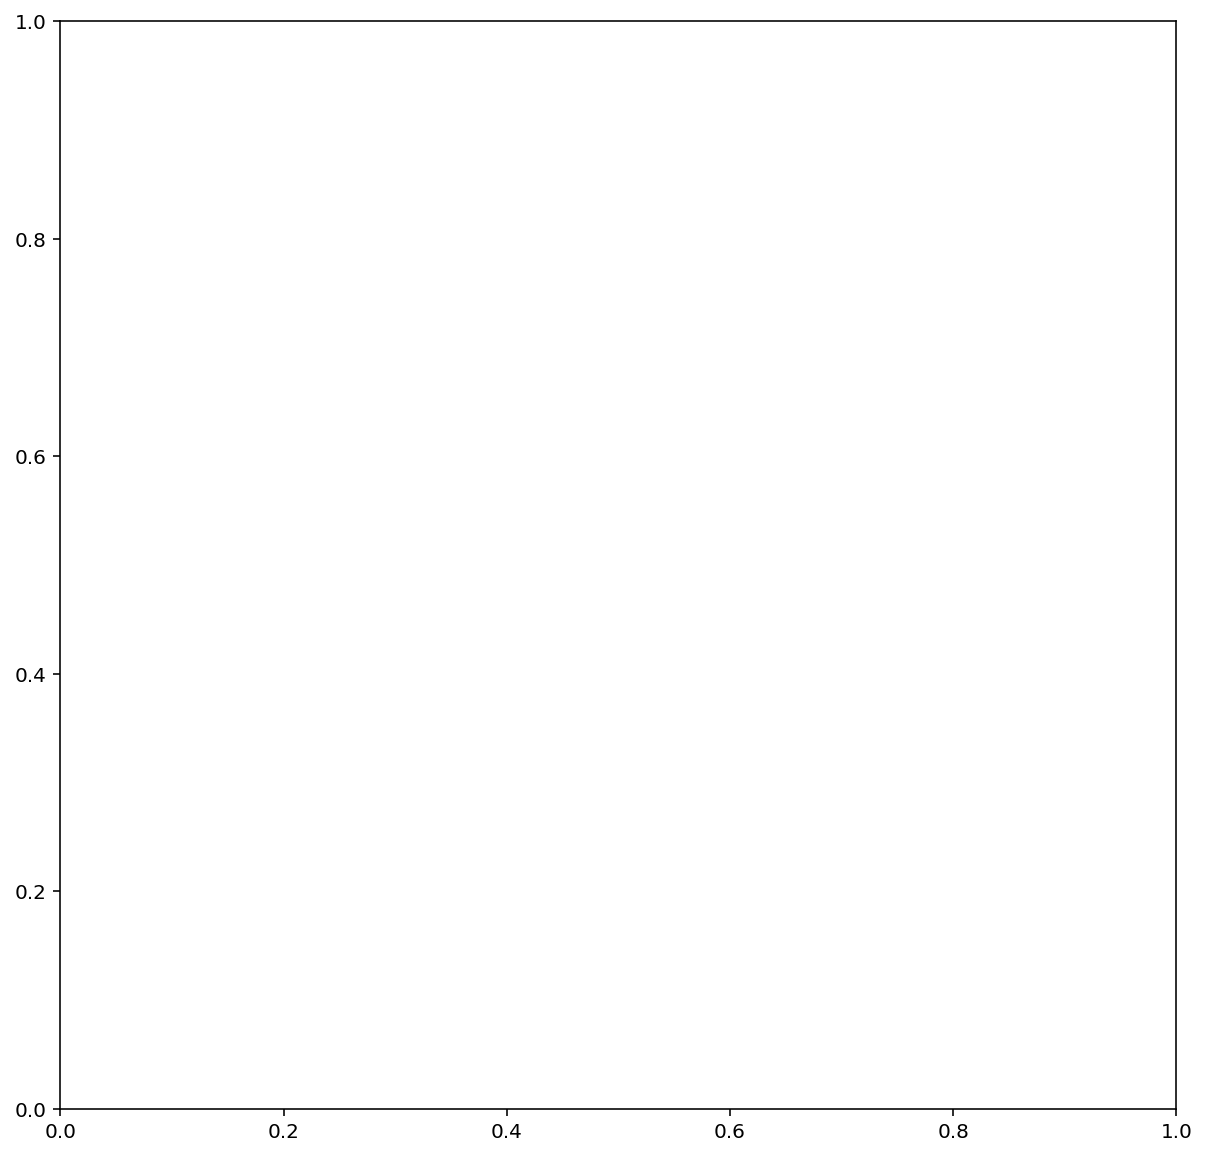

In [52]:
# For 24 Hours: 

WINDOW=24

retweets_after_trump = get_retweets_after_trump(df)

fig = plt.figure()
ax = fig.subplots(1,1)

# example
df2, sr = rank_twitterers(retweets_after_trump[8], retweets_after_trump[15])
ax = df2.plot(kind='scatter',x='rankInA',y='rankInB', figsize=(10,10))

for A in retweets_after_trump.keys():
    for B in retweets_after_trump.keys():
        if B > A:
            print("Tweets: {}, {}".format(A, B))
            print("--------------------")
            df2, sr = rank_twitterers(retweets_after_trump[A], retweets_after_trump[B])
            if df2 is not None:
                ax = df2.plot(kind='scatter',x='rankInA',y='rankInB', figsize=(10,10), ax=ax);
                ax.set_title("rankInA vs. rankInB");
                ax.set_xlabel("Tweet # {}".format(A));
                ax.set_ylabel("Tweet # {}".format(B));
                ax.get_figure().savefig('figs/{}_{}_window={}H.png'.format(A,B,WINDOW), dpi=144);
                ax.clear()
            print()